## Optimal Growth Temperature (OGT): data analysis, processing, and visualization

#### 1. Read the train and test datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.utils import read_ogt_data

TAX_LEVEL = "phylum"
RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../data_ogt/input_data/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../data_ogt/input_data/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = f"../data_ogt/input_data/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../data_ogt/input_data/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../data_ogt/input_data/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = f"../data_ogt/input_data/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 1457, number of features = 3165
Number of samples = 1698, number of features = 3165


In [2]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

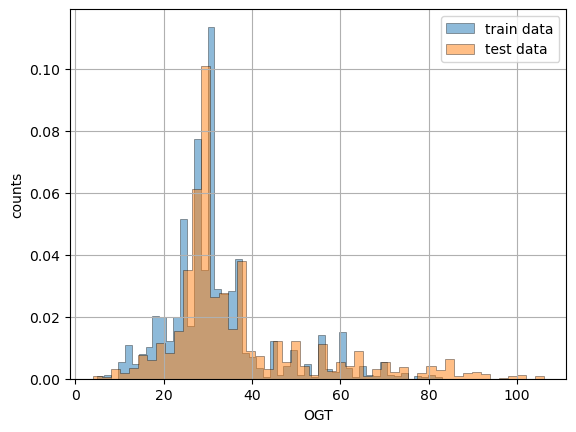

In [3]:
precence_only_flag = False

hist = plt.hist(y_train.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();
plt.savefig(f"{OUTPUT_DIRECTORY}/train_test_data_distr.pdf", format="pdf")

#### 2. PCA and tSNE projections of the training data (colors = temperature)

Data after PCA reduction: (1457, 10)
Shape of the projected data = (1457, 2)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


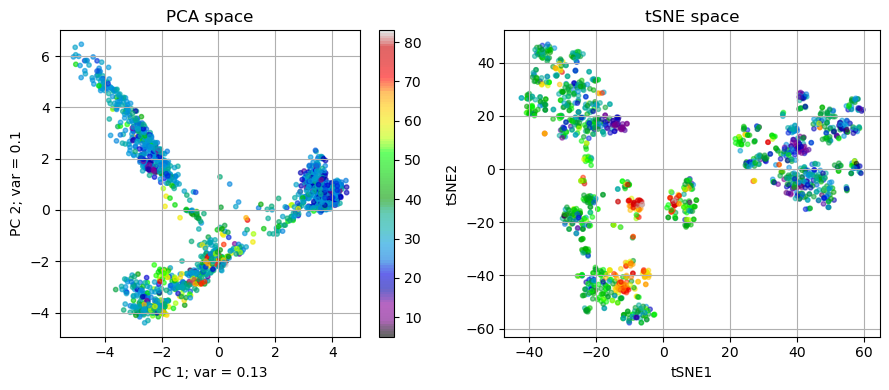

In [4]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phenot.pdf", format="pdf")
plt.show()

#### 2. SetTransformer

In this section, we plot the results for SetTransformers trained for the OGT data. In particular, we visualize the cross-validation predictions for different folds.

The results are visualized for a specified value of the number  of inducing points.

In [9]:
# Axillary function for reading the data 
def read_and_plot(filename, plot_flag=False):
    directory = "../results/SetTransformer/ogt/discrete_predict"
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t")  # Replace with your file path
    
    y_act_to_temp = []
    for categ_i in df['y_actual']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        y_act_to_temp.append(mid_bin_temp)
    predict_to_temp = []
    for categ_i in df['prediction']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        predict_to_temp.append(mid_bin_temp)
    if plot_flag:
        plt.scatter(y_act_to_temp, predict_to_temp, marker='o', alpha = 0.3, c = "tab:blue", s=13)
    return min(y_act_to_temp), max(y_act_to_temp), min(predict_to_temp), max(predict_to_temp), y_act_to_temp, predict_to_temp

In [10]:
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]

# Read the actual OGT and the predicted classes + transform the classes to the temperature
y_act_to_temp_tot = []
predict_to_temp_tot = []
for file in file_names_cv:
    x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file, plot_flag=False)
    y_act_to_temp_tot += y_act_to_temp
    predict_to_temp_tot += predict_to_temp

FileNotFoundError: [Errno 2] No such file or directory: '../results/SetTransformer/ogt/discrete_predict/prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_4.csv'

In [ ]:
# Calculate R^2 and pearson correlation coefficient
r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
print(f"R^2 = {round(r2,2)}")

pcc_scipy, p_value = pearsonr(y_act_to_temp_tot, predict_to_temp_tot)
print(f"PCC = {round(pcc_scipy,2)}")

In [ ]:
# Fit a linear regression model
model = LinearRegression()

x = np.array(y_act_to_temp_tot).reshape(-1, 1)
y = np.array(predict_to_temp_tot)
model.fit(x, y)

# Get predictions for the best-fit line
y_pred = model.predict(x)

In [ ]:
# Create the figure
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot the best-fit line
plt.plot(x, y_pred, color='tab:red', linewidth=2.5, label=f'LinReg')

# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_act_to_temp_tot,
    predict_to_temp_tot,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.xlim([0,110])
plt.ylim([0,110])

# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

# Add labels and a title
plt.title(f'Predicted OGT vs Actual OGT (discrete.), # of induc. points = {ind_point}; R² = {round(r2,2)} | PCC = {round(pcc_scipy,2)}')
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')
plt.legend()
# Show the plot
plt.show()

##### 3. Plot the model accuracy as the function of the number of inducing points

In [ ]:
num_ind_arr = [1, 2, 4, 6, 8, 10, 12]#, 6, 8, 10, 12, 14, 16, 18, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
r2_arr = []

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]
    y_act_to_temp_tot = []
    predict_to_temp_tot = []
    for file in file_names_cv:
        x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file)
        y_act_to_temp_tot += y_act_to_temp
        predict_to_temp_tot += predict_to_temp
    r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
    r2_arr.append(r2)

plt.figure()
plt.scatter(num_ind_arr, r2_arr, s=50)
plt.plot(num_ind_arr, r2_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("R²")
plt.title("Accuracy as a function |of the number of inducing points")
plt.ylim([0.4,0.8])

In [ ]:
# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]


directory = "../results/SetTransformer/ogt/continuous_predict"

y_actual_total = []
y_predict_total = []
for filename in file_names_cv:
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t") 
    y_actual = df["y_actual"].tolist()
    y_predict = df["prediction"].tolist()
    
    y_actual_total += y_actual
    y_predict_total += y_predict

mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    
plt.scatter(y_actual_total, y_predict_total, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')    
plt.title(f'Predicted OGT vs Actual OGT (contin.), # of induc. points = {ind_point}; MSE = {round(mse,2)}; RMSE = {round(np.sqrt(mse),2)}')

In [ ]:
diff = []
for i in range(len(y_actual_total)):
    diff.append(y_actual_total[i] -  y_predict_total[i])
plt.scatter(y_actual_total, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7)    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    

In [ ]:
num_ind_arr = [2, 4, 6, 8, 10, 12, 16, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
mse_arr = []
folds = range(5)
directory = "../results/SetTransformer/ogt/continuous_predict"

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]
  #  print(file_names_cv)
    y_actual_total = []
    y_predict_total = []
    for file in file_names_cv:
        #print(f"{directory}/{file}.csv")
        df = pd.read_csv(f"{directory}/{file}.csv",sep="\t") 
       # print(df)
        y_actual = df["y_actual"].tolist()
        y_predict = df["prediction"].tolist()
        
        y_actual_total += y_actual
        y_predict_total += y_predict
    mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    mse_arr.append(mse)

plt.figure()
plt.scatter(num_ind_arr, mse_arr, s=50)
plt.plot(num_ind_arr, mse_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("MSE")
plt.title("Accuracy as a function of the number of inducing points")
plt.ylim([25,50])

#### 2. XGBoost: classification


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
#Add XGBoost
ogt_continuous_flag = False
num_classes = 30
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)

print(np.unique(y_train.cpu().numpy()))
print(len(np.unique(y_train.cpu().numpy())))
print(np.unique(y_test.cpu().numpy()))

In [ ]:
from sklearn.model_selection import cross_val_predict, KFold
from xgboost import XGBRegressor


num_classes = len(np.unique(y_train.cpu().numpy().astype(int)))

model = XGBClassifier(
    n_jobs=-1,                # Use all CPU cores
    tree_method="hist",   # Use "hist" for CPU, "gpu_hist" for GPU
    objective="multi:softmax",  # Default loss function for regression
    #n_estimators=35,
    num_class = num_classes,
)

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

kf  = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

y_true_list = []
y_pred_list = []

y_train_int = y_train.cpu().numpy().astype(int) 

for train_idx, test_idx in kf.split(X_train, y_train_int):
    y_fold_train = y_train[train_idx]
    print("Unique classes in this fold:", np.unique(y_fold_train))
    
    X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

    model.fit(X_fold_train, y_fold_train.numpy().astype(int))
    y_pred_fold = model.predict(X_fold_test)

    y_true_list.append(y_fold_test)
    y_pred_list.append(y_pred_fold)

# Convert lists to arrays
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

print(len(y_true))
print(len(y_pred))

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

In [ ]:
# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_true,
    y_pred,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
x_max=30
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.grid(True)
#plt.xlim([0,110])
#plt.ylim([0,110])

# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

In [ ]:
train_accuracy = accuracy_score(y_train.cpu(), model.predict(X_train.cpu()))
test_accuracy = accuracy_score(y_test.cpu(), model.predict(X_test.cpu()))
print(f"train_accuracy = {train_accuracy}; test_accuracy = {test_accuracy}")

In [ ]:
model.fit(X_train.cpu(), y_train.cpu().numpy())
y_pred = model.predict(X_test.cpu()) 

#### 3. XGBoost training and feature selection


First, we train XGBoost on the full train dataset and examine RMSE and R2 from the cross-validation during training

In [5]:
from utils.utils import train_xgboost
from sklearn.metrics import mean_squared_error,r2_score

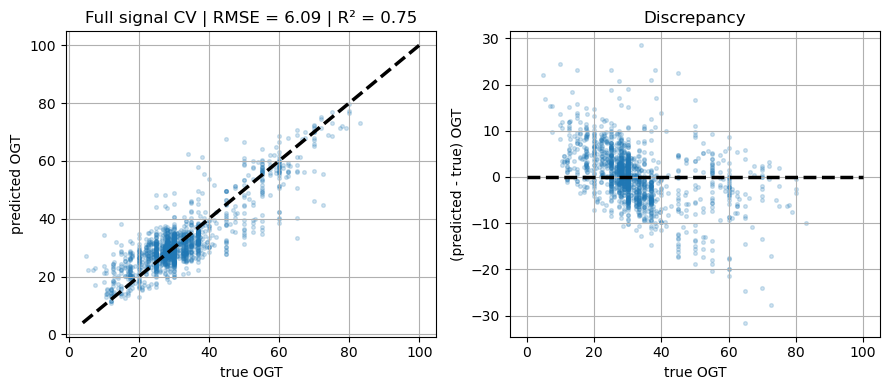

In [6]:
plt.figure(figsize=(9, 4))

# Cross-Validation: full signal
plt.subplot(1, 2, 1) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Full signal CV | RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Cross-Validation: diff for full signal
plt.subplot(1, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_accuracy_all_feat.pdf", format="pdf")
plt.show()

Second, we train XGBoost on the full train dataset and examine RMSE and R2 from running the trained model on the test dataset.

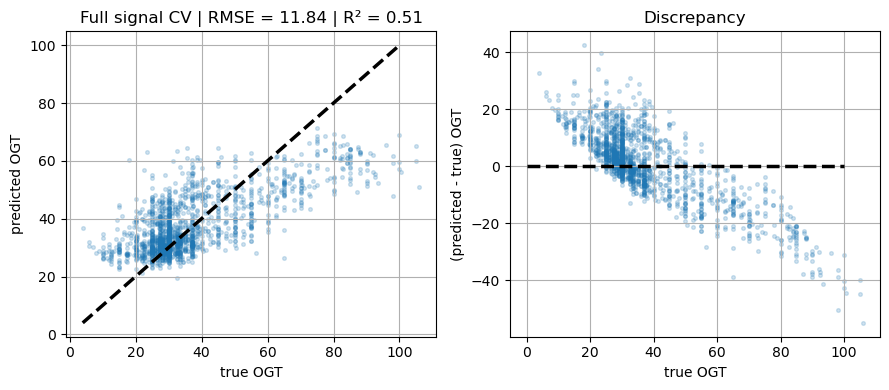

In [7]:
plt.figure(figsize=(9, 4))

# Full signal
plt.subplot(1, 2, 1) 
#precence_only_flag = False
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Full signal CV | RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(1, 2, 2) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout() 
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_test_accuracy_all_feat.pdf", format="pdf")

plt.show()

### 2. Feature selection

#### 2.1. Feature space

In [8]:
#precence_only_flag = False
#ogt_continuous_flag = True
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
#X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T
print(f"X_train_transposed shape = {X_train_transposed.shape}")

X_train_transposed shape = (3165, 1457)


Data after PCA reduction: (3165, 10)
Shape of the projected data = (3165, 2)


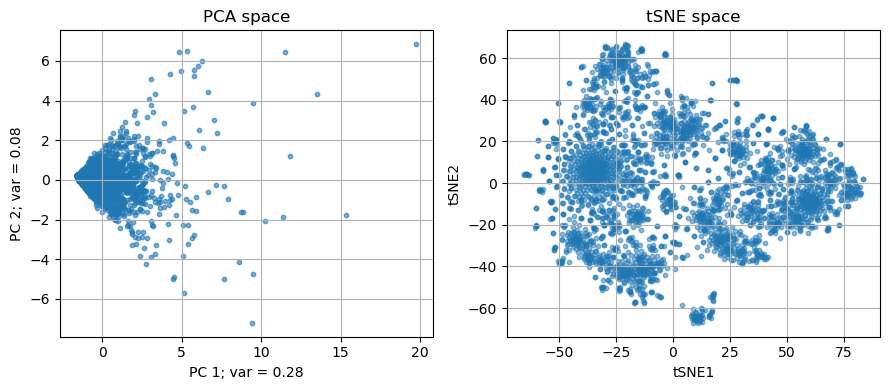

In [19]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train_transposed, n_compon);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train_transposed, 20, 100, RANDOM_SEED, None);

# Display the plots
plt.tight_layout()  
plt.show()

#### 3.1 Feature selection with Mutual Information

In [9]:
from feature_selection.feature_selection_utils import mutual_info_features

#precence_only_flag = True
#ogt_continuous_flag = True
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(DEVICE, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train, y_train, X_column_names, contin_flag = True)

X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(len(top_feat_mi_counts[0]))

print(f"Top {N} COGs:", top_N_names_by_mi)

1457
Top 30 COGs: ['K10804', 'K01256', 'K15977', 'K02199', 'K03772', 'K08234', 'K00655', 'K06158', 'K03321', 'K03797', 'K03668', 'K07277', 'K03654', 'K04763', 'K03701', 'K02477', 'K03790', 'K03088', 'K02171', 'K07114', 'K00754', 'K06975', 'K03704', 'K19304', 'K07305', 'K09667', 'K01055', 'K02276', 'K09808', 'K03719']


Data after PCA reduction: (1457, 10)
Shape of the projected data = (1457, 2)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


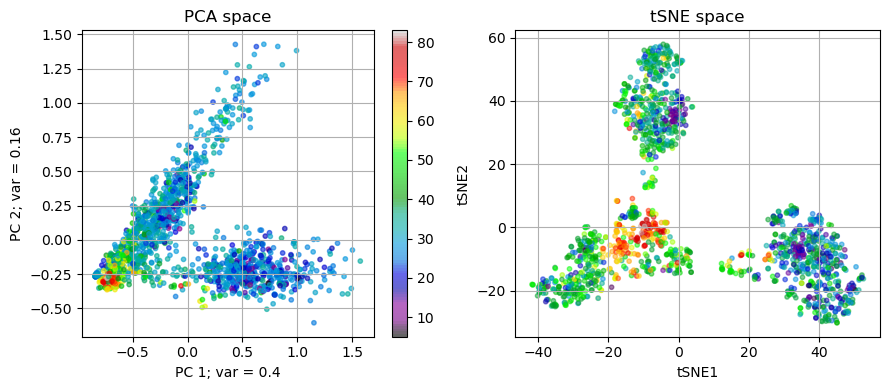

In [11]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_mi_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_mi_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_mi_feat.pdf", format="pdf")
plt.show()

In [12]:
from utils.utils import train_xgboost
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from sklearn.preprocessing import MaxAbsScaler

y_train, y_test = y_train.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train, X_test.cpu(), y_test) 

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 11.84, R2 = 0.51
XGBoost baseline CV RMSE (all features) = 6.09, R2 = 0.75


In [13]:
from utils.utils import xgboost_accuracy_contin   


feat_step = 10
feat_removal = False
rmse_test_arr_mi, r2_test_arr_mi, rmse_cv_arr_mi, r2_cv_arr_mi, num_feat_plot   = xgboost_accuracy_contin(X_train.cpu(), X_test.cpu(), y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [14]:
feat_removal = True
rmse_test_arr_mi_rem, r2_test_arr_mi_rem, rmse_cv_arr_mi_rem, r2_cv_arr_mi_rem, num_feat_plot_rem   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

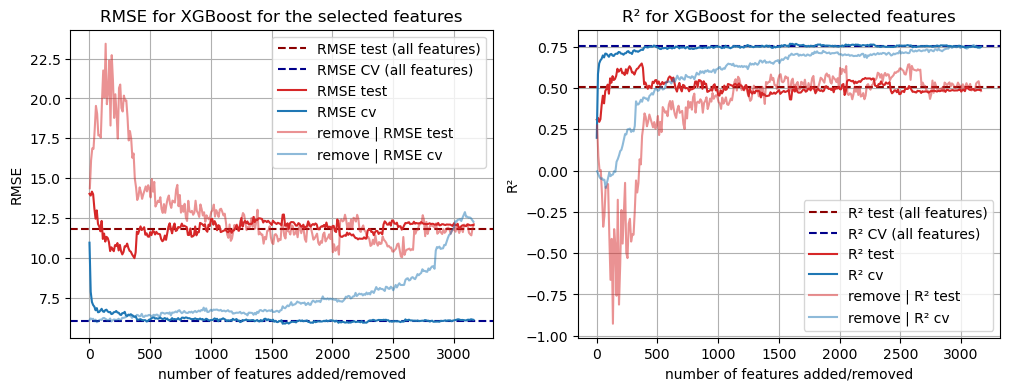

In [15]:
plt.figure(figsize=(12, 4))
tot_num_feat = X_train.cpu().shape[1]
plt.subplot(1, 2, 1)
plt.axhline(y=rmse_test, color='darkred', linestyle='--', linewidth=1.5, label='RMSE test (all features)')
plt.axhline(y=rmse_cv, color='darkblue', linestyle='--', linewidth=1.5, label='RMSE CV (all features)')
plt.plot(num_feat_plot, rmse_test_arr_mi, c = "tab:red", label = "RMSE test")
plt.plot(num_feat_plot, rmse_cv_arr_mi, c = "tab:blue", label = "RMSE cv")

plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], rmse_test_arr_mi_rem, c = "tab:red", label = "remove | RMSE test", alpha = 0.5)
plt.plot(num_feat_plot_rem, rmse_cv_arr_mi_rem, c = "tab:blue", label = "remove | RMSE cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("RMSE")
plt.title("RMSE for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(y=r2_test, color='darkred', linestyle='--', linewidth=1.5, label='R² test (all features)')
plt.axhline(y=r2_cv, color='darkblue', linestyle='--', linewidth=1.5, label='R² CV (all features)')
plt.plot(num_feat_plot, r2_test_arr_mi, c = "tab:red", label = "R² test")
plt.plot(num_feat_plot, r2_cv_arr_mi, c = "tab:blue", label = "R² cv")

plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], r2_test_arr_mi_rem, c = "tab:red", label = "remove | R² test", alpha = 0.5)
plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], r2_cv_arr_mi_rem, c = "tab:blue", label = "remove | R² cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("R²")
plt.title("R² for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat.pdf", format="pdf")

plt.show()

#### 3.2 Feature selection with Random Forest

In [16]:
from feature_selection.feature_selection_utils import random_forest_features

#precence_only_flag = True
#ogt_continuous_flag = True
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(DEVICE, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_train, y_train, X_column_names, contin_flag = True)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Original feature count: 3165, Selected feature count: 279


In [17]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 30 COGs: ['K06207', 'K06158', 'K09457', 'K06970', 'K05810', 'K11473', 'K07443', 'K13282', 'K03170', 'K11392', 'K09164', 'K19091', 'K07590', 'K06969', 'K16167', 'K01142', 'K01480', 'K06390', 'K02398', 'K03610', 'K02392', 'K09951', 'K07482', 'K06416', 'K09931', 'K03402', 'K09141', 'K11530', 'K09166', 'K01876']


Data after PCA reduction: (1457, 10)
Shape of the projected data = (1457, 2)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


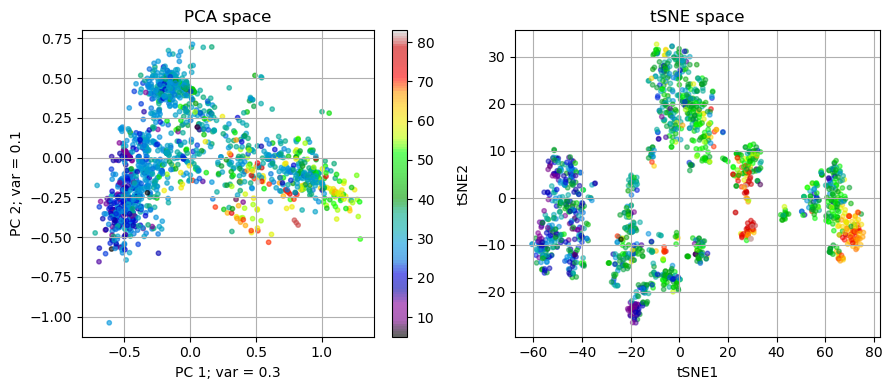

In [18]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_forest_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_forest_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [19]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 10
feat_removal = False
rmse_test_arr_randfor, r2_test_arr_randfor, rmse_cv_arr_randfor, r2_cv_arr_randfor, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [20]:
feat_removal = True
rmse_test_arr_randfor_rem, r2_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, r2_cv_arr_randfor_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

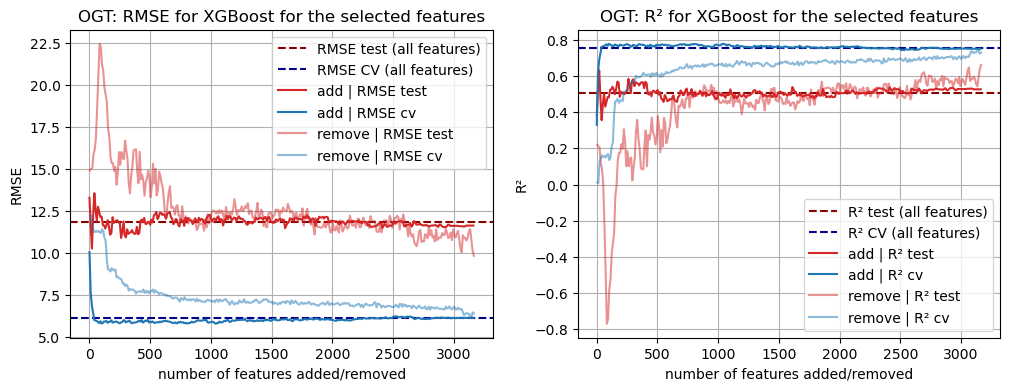

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=rmse_test, color='darkred', linestyle='--', linewidth=1.5, label='RMSE test (all features)')
plt.axhline(y=rmse_cv, color='darkblue', linestyle='--', linewidth=1.5, label='RMSE CV (all features)')
plt.plot(num_feat_plot, rmse_test_arr_randfor, c = "tab:red", label = "add | RMSE test")
plt.plot(num_feat_plot, rmse_cv_arr_randfor, c = "tab:blue", label = "add | RMSE cv")

plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], rmse_test_arr_randfor_rem, c = "tab:red", label = "remove | RMSE test", alpha = 0.5)
plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], rmse_cv_arr_randfor_rem, c = "tab:blue", label = "remove | RMSE cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("RMSE")
plt.title("OGT: RMSE for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(y=r2_test, color='darkred', linestyle='--', linewidth=1.5, label='R² test (all features)')
plt.axhline(y=r2_cv, color='darkblue', linestyle='--', linewidth=1.5, label='R² CV (all features)')
plt.plot(num_feat_plot, r2_test_arr_randfor, c = "tab:red", label = "add | R² test")
plt.plot(num_feat_plot, r2_cv_arr_randfor, c = "tab:blue", label = "add | R² cv")

plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], r2_test_arr_randfor_rem, c = "tab:red", label = "remove | R² test", alpha = 0.5)
plt.plot([tot_num_feat - n  for n in num_feat_plot_rem], r2_cv_arr_randfor_rem, c = "tab:blue", label = "remove | R² cv", alpha = 0.5)

plt.xlabel("number of features added/removed") #TODO more folds
plt.ylabel("R²")
plt.title("OGT: R² for XGBoost for the selected features")
plt.grid()
plt.legend()
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_randfor_feat.pdf", format="pdf")
plt.show()

#### 3.3 Feature selection with SHAP values

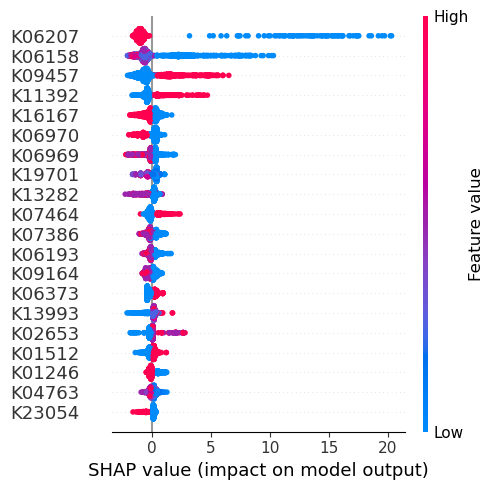

In [22]:
from feature_selection.feature_selection_utils import shap_features

#precence_only_flag = True
#ogt_continuous_flag = True
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(DEVICE, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
contin_flag = True
sorted_cog_idx_by_shap, sorted_importances, sorted_names = shap_features(X_train, y_train, X_column_names, DEVICE, contin_flag)

In [27]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_rand_shap = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]
print(f"Top {N} COGs:", top_N_names_by_shap)

Top 30 COGs: ['K06207', 'K06158', 'K09457', 'K11392', 'K16167', 'K06970', 'K06969', 'K19701', 'K13282', 'K07464', 'K07386', 'K06193', 'K09164', 'K06373', 'K13993', 'K02653', 'K01512', 'K01246', 'K04763', 'K23054', 'K07443', 'K03701', 'K00175', 'K08303', 'K08970', 'K01876', 'K02199', 'K03282', 'K04095', 'K03294']


Data after PCA reduction: (1457, 10)
Shape of the projected data = (1457, 2)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


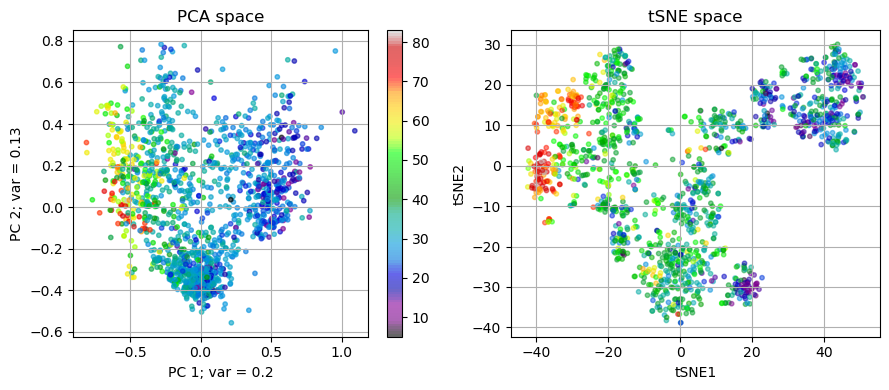

In [28]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_shap).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_shap).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [29]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 10
feat_removal = False
rmse_test_arr_shap, r2_test_arr_shap, rmse_cv_arr_shap, r2_cv_arr_shap, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

In [30]:
feat_removal = True
rmse_test_arr_shap_rem, r2_test_arr_shap_rem, rmse_cv_arr_shap_rem, r2_cv_arr_shap_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=rmse_test, color='darkred', linestyle='--', linewidth=1.5, label='RMSE test (all features)')
plt.axhline(y=rmse_cv, color='darkblue', linestyle='--', linewidth=1.5, label='RMSE CV (all features)')
plt.plot(num_feat_plot, rmse_test_arr_randfor, c = "tab:red", label = "add | RMSE test")
plt.plot(num_feat_plot, rmse_cv_arr_randfor, c = "tab:blue", label = "add | RMSE cv")

plt.plot(num_feat_plot_rem, rmse_test_arr_randfor_rem, c = "tab:red", label = "remove | RMSE test", alpha = 0.5)
plt.plot(num_feat_plot_rem, rmse_cv_arr_randfor_rem, c = "tab:blue", label = "remove | RMSE cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("RMSE")
plt.title("OGT: RMSE for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(y=r2_test, color='darkred', linestyle='--', linewidth=1.5, label='R² test (all features)')
plt.axhline(y=r2_cv, color='darkblue', linestyle='--', linewidth=1.5, label='R² CV (all features)')
plt.plot(num_feat_plot, r2_test_arr_randfor, c = "tab:red", label = "add | R² test")
plt.plot(num_feat_plot, r2_cv_arr_randfor, c = "tab:blue", label = "add | R² cv")

plt.plot(num_feat_plot_rem, r2_test_arr_randfor_rem, c = "tab:red", label = "remove | R² test", alpha = 0.5)
plt.plot(num_feat_plot_rem, r2_cv_arr_randfor_rem, c = "tab:blue", label = "remove | R² cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("R²")
plt.title("OGT: R² for XGBoost for the selected features")
plt.grid()
plt.legend()
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat.pdf", format="pdf")
plt.show()

#### 4. Feature comparison

In [39]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

,MI,RandomForest,SHAP
0,K06158,K06207,K06158
1,K08234,K06158,K06207
2,K10804,K03170,K03170
3,K02199,K06416,K06416
4,K00655,K19091,K06970
5,K15977,K06970,K19091
6,K03654,K06390,K13993
7,K03088,K06168,K11392
8,K03296,K07560,K07568
9,K03704,K06983,K07178


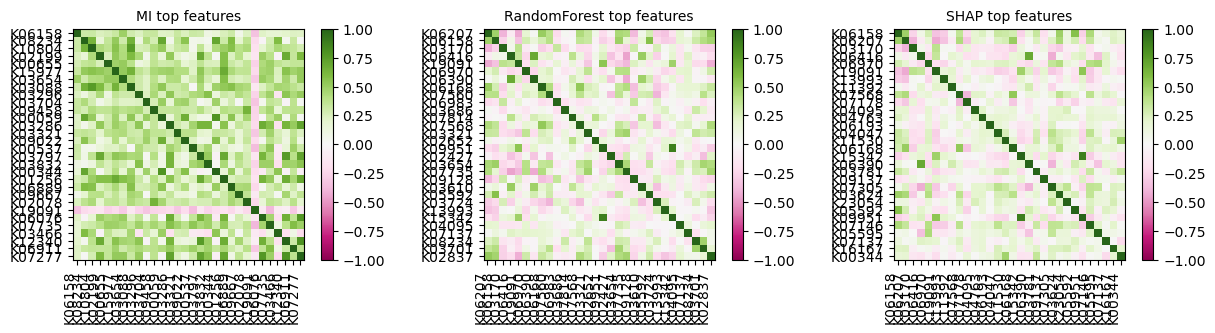

In [40]:
plt.figure(figsize=(15, 3))

vmin, vmax = -1, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RANDOM Forest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_rand_shap)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")

In [41]:
# Number of selected features to add/remove from the list of top features
N = 3000
ogt_continuous_flag = True
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

plt.figure(figsize=(12.5, 12.5))

# MI top features signal
select_feat_mi = list(sorted_cog_idx_by_mi[:N])
X_train_select_feat = X_train[:, select_feat_mi]
X_test_select_feat = X_test[:, select_feat_mi]

select_feat_mi_rem = list(sorted_cog_idx_by_mi[N:])
X_train_select_feat_rem = X_train[:, select_feat_mi_rem]
X_test_select_feat_rem = X_test[:, select_feat_mi_rem]

# 1: MI top N predict
plt.subplot(4, 4, 1) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 5: Diff for MI top N predict
plt.subplot(4, 4, 5) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 9: MI top N predict: test
plt.subplot(4, 4, 9) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 13: Diff for MI top N predict
plt.subplot(4, 4, 13) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 2: MI w/o top N predict
plt.subplot(4, 4, 2) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 6: Diff for MI w/o top N predict
plt.subplot(4, 4, 6) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 10: MI w/o N predict: test
plt.subplot(4, 4, 10) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 14: Diff for MI top N predict
plt.subplot(4, 4, 14) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# RandomForest only signal
select_feat_ranfor = list(sorted_cog_idx_by_rand_forest[:N])
X_train_select_feat = X_train[:, select_feat_ranfor]
X_test_select_feat = X_test[:, select_feat_ranfor]

select_feat_ranfor_rem = list(sorted_cog_idx_by_rand_forest[N:])
X_train_select_feat_rem = X_train[:, select_feat_ranfor_rem]
X_test_select_feat_rem = X_test[:, select_feat_ranfor_rem]

#3: RandomForest top N predict
plt.subplot(4, 4, 3) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#7: Diff RandomForest top N predict
plt.subplot(4, 4, 7) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 11: RandomForest top N predict: test
plt.subplot(4, 4, 11) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 15: Diff for RandomForest top N predict
plt.subplot(4, 4, 15) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

#4: RandomForest w/o top N predict
plt.subplot(4, 4, 4) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#8: Diff RandomForest w/o top N predict
plt.subplot(4, 4, 8) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 12: RandomForest top N predict: test
plt.subplot(4, 4, 12) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 16: Diff for RandomForest w/o top N predict
plt.subplot(4, 4, 16) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='^', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

num_coinc = len(set(select_feat_mi) & set(select_feat_ranfor))
print(f"Number of coinciding COGs =  {num_coinc}, which is {round(100*num_coinc/N,2)}%")

plt.savefig(f"{OUTPUT_DIRECTORY}/examples_top{N}_feat.pdf", format="pdf")

NameError: name 'device' is not defined